# Somalia displacement case study - CIMA vs BEM

This notebook compares (flood) displacement risk in Somalia estimated with two different exposure and associated vulnerability models.

## Make/Load Hazard

Load the return period flood maps.

In [2]:
from climada.hazard import Hazard

In [3]:
import numpy as np
from pathlib import Path

In [4]:
HAZ_TYPE = 'FL'

In [5]:
HAZ_FOLDER = Path('/Users/simonameiler/Documents/WCR/Displacement/Somalia_CIMA_example/Hazard/HISTORICAL/')

In [6]:
haz_files = [str(file) for file in HAZ_FOLDER.glob('*.tif')]
rp = np.array([int(Path(file).stem[-4:]) for file in haz_files])

In [7]:
haz = Hazard.from_raster(
    haz_type=HAZ_TYPE, files_intensity=haz_files, src_crs='WGS84',
    attrs={'unit': 'm', 'event_id': np.arange(len(haz_files)), 'frequency':1/rp}
)

In [8]:
# convert intensity given in cm to m
haz.intensity = haz.intensity/100

In [9]:
haz.intensity.max(axis=1).data

array([5.56     , 6.8173584, 6.03     , 7.39     , 7.1      , 6.4      ,
       4.65     , 3.53     ])

## BEM exposure model

### Load Exposures and Impact function set

In [10]:
from climada.entity.exposures import Exposures
import numpy as np
import os

os.chdir('/Users/simonameiler/Documents/WCR/Displacement/global-displacement-risk') # change back to root folder, not "~/doc"
import exposure
import vulnerability

In [11]:
cntry_name = 'Somalia'

### BEM subcomponents

These are derived from country-wise `.csv` files.
The following functions load them into `GeoDataFrames`, adding coordinates from a separate file.

To convert them into formats usable as `Exposures()`, a few processing options are available (work in progress).

In [12]:
# Load the full dataframe, without further re-aggregation / processing other than adding centroids
gdf_bem_subcomps = exposure.gdf_from_bem_subcomps(cntry_name, opt='full')
gdf_bem_subcomps.head()

,id_1x,iso3,cpx,sector,se_seismo,valhum,valfis,bd_1_floor,bd_2_floor,bd_3_floor,geometry
0,174025676,SOM,3,beds_priv,W2,0.000342,5.179267e-07,100.0,0.0,0.0,POINT (50.54583 11.86250)
1,174025676,SOM,3,beds_priv,W1,0.000146,2.214579e-07,100.0,0.0,0.0,POINT (50.54583 11.86250)
2,174025676,SOM,3,beds_priv,UCB,0.000005,7.143810e-09,100.0,0.0,0.0,POINT (50.54583 11.86250)
3,174025676,SOM,3,beds_priv,RS2,0.000038,5.715046e-08,100.0,0.0,0.0,POINT (50.54583 11.86250)
4,174025676,SOM,3,beds_priv,INF,0.000014,2.143141e-08,100.0,0.0,0.0,POINT (50.54583 11.86250)


Info on the meaning of the columns can be found in the UNEP-GRID technical documentation and further references. The centroids (id_1x / geometry) is multiply defined, each separate sector-se_seismo combo has its unique row.

While there are 8 different building types, we can simply define impact functions for all of these, and make a `CLIMADA` exposure from it (in which centroids are multiply defined).

In [13]:
# filter and apply impf id
gdf_bem_subcomps = gdf_bem_subcomps[gdf_bem_subcomps.valhum>0.001] # filter out rows with basically no population
gdf_bem_subcomps['impf_FL'] = gdf_bem_subcomps.apply(lambda row: vulnerability.DICT_PAGER_FLIMPF_IVM[row.se_seismo], axis=1)

In [14]:
# replace impf 3 --> 5 for 2-storeys and more
gdf_bem_subcomps.loc[((gdf_bem_subcomps.bd_3_floor+gdf_bem_subcomps.bd_2_floor)>0.5)
                     &(gdf_bem_subcomps.impf_FL==3), "impf_FL"] = 5

In [15]:
# replace impf 4 --> 6 for 2-storeys and more
gdf_bem_subcomps.loc[((gdf_bem_subcomps.bd_3_floor+gdf_bem_subcomps.bd_2_floor)>0.5)
                     &(gdf_bem_subcomps.impf_FL==4), "impf_FL"] = 6

In [16]:
# remove for now unnecessary cols and prepare gdf for CLIMADA Exposure
gdf_bem_subcomps.rename({'valhum' : 'value'}, axis=1)
for col in ['iso3', 'sector', 'valfis', 'se_seismo']:
    gdf_bem_subcomps.pop(col)

Make CLIMADA Exposure with mutliply defined centroids

In [17]:
exp_bem_ivm = Exposures(gdf_bem_subcomps)
exp_bem_ivm.gdf.rename({'valhum': 'value'}, axis=1, inplace=True)
exp_bem_ivm.value_unit = 'Pop. count'
exp_bem_ivm.gdf['longitude'] = exp_bem_ivm.gdf.geometry.x
exp_bem_ivm.gdf['latitude'] = exp_bem_ivm.gdf.geometry.y
exp_bem_ivm.gdf = exp_bem_ivm.gdf[~np.isnan(
    exp_bem_ivm.gdf.latitude)]  # drop nan centroids
exp_bem_ivm.gdf.head()

,id_1x,cpx,value,bd_1_floor,bd_2_floor,bd_3_floor,geometry,impf_FL,longitude,latitude
6,194457751,3,0.003283,0.0,0.0,0.0,POINT (43.40417 0.66250),2,43.404167,0.6625
7,194457751,3,0.001404,0.0,0.0,0.0,POINT (43.40417 0.66250),2,43.404167,0.6625
12,194457751,3,0.002711,0.0,0.0,0.0,POINT (43.40417 0.66250),2,43.404167,0.6625
13,194457751,3,0.001159,0.0,0.0,0.0,POINT (43.40417 0.66250),2,43.404167,0.6625
18,194457751,3,0.281569,0.0,0.0,0.0,POINT (43.40417 0.66250),2,43.404167,0.6625


In [18]:
impf_set_fl = vulnerability.IMPF_SET_FL_IVM

array([[<Axes: title={'center': 'FL 1: Flood impact function class I'}, xlabel='Intensity (metres)', ylabel='Impact (%)'>,
        <Axes: title={'center': 'FL 2: Flood impact function class II'}, xlabel='Intensity (metres)', ylabel='Impact (%)'>,
        <Axes: title={'center': 'FL 3: Flood impact function class III - one storey'}, xlabel='Intensity (metres)', ylabel='Impact (%)'>],
       [<Axes: title={'center': 'FL 5: Flood impact function class III - two storeys'}, xlabel='Intensity (metres)', ylabel='Impact (%)'>,
        <Axes: title={'center': 'FL 4: Flood impact function class IV - one storey'}, xlabel='Intensity (metres)', ylabel='Impact (%)'>,
        <Axes: title={'center': 'FL 6: Flood impact function class IV - two storeys'}, xlabel='Intensity (metres)', ylabel='Impact (%)'>]],
      dtype=object)

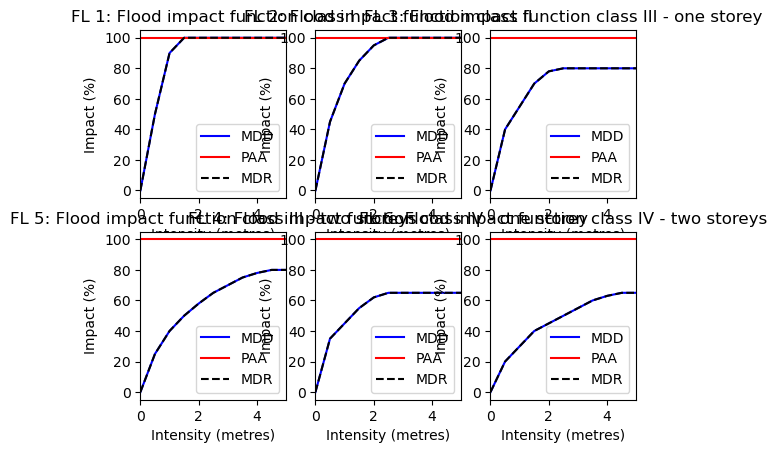

In [19]:
impf_set_fl.plot()

Generate step function from PAGER building types

In [20]:
from climada.entity import ImpactFunc, ImpactFuncSet
impf_set_ivm_step = ImpactFuncSet()

# The threshold of building damage after which all people are displaced. Below, no-one is displaced.
building_thes = 0.55 # 55% iDMC v1; CIMA: 30% for Somalia to 60% for other countries. 

for imp_id in impf_set_fl.get_ids(haz_type='FL'):
    impf_set_fl.get_func(fun_id=imp_id)
    y = impf_set_fl.get_func(fun_id=imp_id)[0].intensity
    x = impf_set_fl.get_func(fun_id=imp_id)[0].mdd
    flood_thres = np.interp(building_thes, x, y)
    print('ID: '+str(imp_id)+' - threshold stepfunction: '+str(flood_thres))
    impf_set_ivm_step.append(
                ImpactFunc.from_step_impf(
                    intensity=(0,  flood_thres, flood_thres *10),
                    haz_type='FL',
                    impf_id=imp_id,
                    intensity_unit = 'm'
                )
    )

ID: 1 - threshold stepfunction: 0.5625
ID: 2 - threshold stepfunction: 0.7000000000000002
ID: 3 - threshold stepfunction: 1.0
ID: 5 - threshold stepfunction: 1.8125000000000004
ID: 4 - threshold stepfunction: 1.5
ID: 6 - threshold stepfunction: 3.0


array([[<Axes: title={'center': 'FL 1: '}, xlabel='Intensity (m)', ylabel='Impact (%)'>,
        <Axes: title={'center': 'FL 2: '}, xlabel='Intensity (m)', ylabel='Impact (%)'>,
        <Axes: title={'center': 'FL 3: '}, xlabel='Intensity (m)', ylabel='Impact (%)'>],
       [<Axes: title={'center': 'FL 5: '}, xlabel='Intensity (m)', ylabel='Impact (%)'>,
        <Axes: title={'center': 'FL 4: '}, xlabel='Intensity (m)', ylabel='Impact (%)'>,
        <Axes: title={'center': 'FL 6: '}, xlabel='Intensity (m)', ylabel='Impact (%)'>]],
      dtype=object)

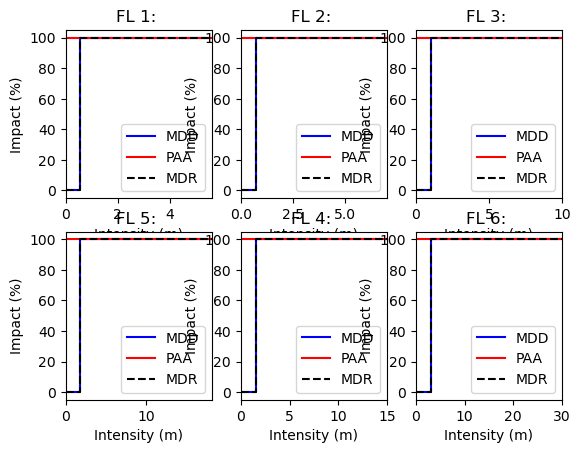

In [21]:
impf_set_ivm_step.plot()

### Impacts

#### Historical

In [22]:
from climada.engine import ImpactCalc

In [47]:
impcalc = ImpactCalc(exp_bem_ivm, impf_set_ivm_step, haz)
impact_bem = impcalc.impact()

In [48]:
# Compared to the ~40'000 reported by CIMA using the probabilistic hazard set
impact_bem.aai_agg

107376.26532230548

In [25]:
freqd_curve_bem = impact_bem.calc_freq_curve(return_per = np.arange(1, 250, 1))

<Axes: title={'center': 'Exceedance frequency curve'}, xlabel='Return period (year)', ylabel='Impact (Pop. count)'>

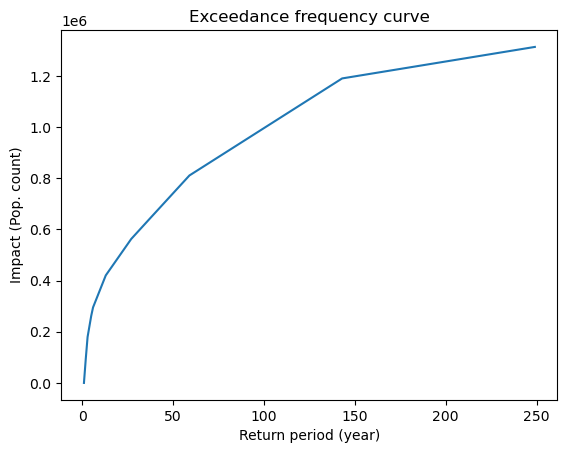

In [26]:
freqd_curve_bem.plot()

## CIMA exposure & vulernability functions

### Load exp and Impf

Once saved to file, the exposures and impact function can be loaded directly.

In [27]:
# Define certain default values

# How many of the employed people are displaced due to their work building beeing damaged, fixed bei CIMA
EMPLOYED_FRACTION = 0.35 

# Worldbank data, how many additional people are displaced when a worker is displaced (e.g., kids) 
# Is equal to the ratio of the non-working population (people age 0-15 and 65-) over the working population (people age 15-65)
# Can be retrieved from various sources, e.g., Worldbank.
DEPENDENCY_RATIO = 0.94 

In [28]:
IMPF_FOLDER = Path('/Users/simonameiler/Documents/WCR/Displacement/Somalia_CIMA_example/Curve/')

# The threshold of building damage after which all people are displaced. Below, no-one is displaced.
BUILD_THRES = 0.3 # from 30% for Somalia to 60% for other countries. Defined by CIMA.

In [51]:
from climada.entity import Exposures
exp_cima = Exposures.from_hdf5('/Users/simonameiler/Documents/WCR/Displacement/Somalia_CIMA_example/somalia_people_flood_displacement_exp_final.hdf5')

In [54]:
exp_cima.gdf['impf_FL'] = exp_cima.gdf.apply(lambda row: vulnerability.DICT_CIMA_FLIMPF_CIMA[row.building_type], axis=1)

In [55]:
exp_cima.gdf.head()

,building_type,longitude,latitude,value,value_unit,impf_RF,impf_FL
0,C1,41.000417,0.392083,1.700305e-09,pop,1,1
1,C1,41.000417,0.392917,1.700305e-09,pop,1,1
2,C1,41.000417,0.393750,2.140250e-03,pop,1,1
3,C1,41.000417,0.394583,8.755529e-02,pop,1,1
4,C1,41.000417,0.395417,1.389257e-01,pop,1,1


In [56]:
impf_set_cima = vulnerability.IMPF_SET_FL_CIMA

In [57]:
impf_set_cima_step = ImpactFuncSet()

# The threshold of building damage after which all people are displaced. Below, no-one is displaced.
building_thes = 0.3 # 55% iDMC v1; CIMA: 30% for Somalia to 60% for other countries. 

for imp_id in impf_set_cima.get_ids(haz_type='FL'):
    impf_set_cima.get_func(fun_id=imp_id)
    y = impf_set_cima.get_func(fun_id=imp_id)[0].intensity
    x = impf_set_cima.get_func(fun_id=imp_id)[0].mdd
    flood_thres = np.interp(BUILD_THRES, x, y)
    impf_set_cima_step.append(
                ImpactFunc.from_step_impf(
                    intensity=(0,  flood_thres, flood_thres *10),
                    haz_type='FL',
                    impf_id=imp_id,
                    intensity_unit = 'm'
                )
    )

array([[<Axes: title={'center': 'FL 1: '}, xlabel='Intensity (m)', ylabel='Impact (%)'>,
        <Axes: title={'center': 'FL 2: '}, xlabel='Intensity (m)', ylabel='Impact (%)'>,
        <Axes: title={'center': 'FL 3: '}, xlabel='Intensity (m)', ylabel='Impact (%)'>],
       [<Axes: title={'center': 'FL 4: '}, xlabel='Intensity (m)', ylabel='Impact (%)'>,
        <Axes: title={'center': 'FL 5: '}, xlabel='Intensity (m)', ylabel='Impact (%)'>,
        <Axes: title={'center': 'FL 6: '}, xlabel='Intensity (m)', ylabel='Impact (%)'>],
       [<Axes: title={'center': 'FL 7: '}, xlabel='Intensity (m)', ylabel='Impact (%)'>,
        <Axes: title={'center': 'FL 8: '}, xlabel='Intensity (m)', ylabel='Impact (%)'>,
        <Axes: title={'center': 'FL 9: '}, xlabel='Intensity (m)', ylabel='Impact (%)'>],
       [<Axes: title={'center': 'FL 10: '}, xlabel='Intensity (m)', ylabel='Impact (%)'>,
        <Axes: title={'center': 'FL 11: '}, xlabel='Intensity (m)', ylabel='Impact (%)'>,
        <Axes: t

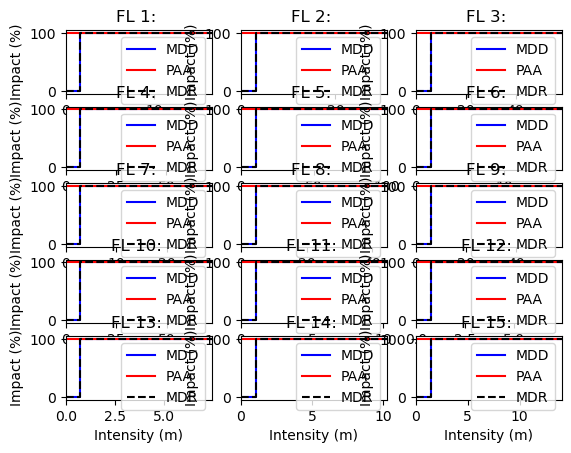

In [49]:
impf_set_cima_step.plot()

In [58]:
impcalc = ImpactCalc(exp_cima, impf_set_cima_step, haz)
impact_cima = impcalc.impact()

In [59]:
# Compared to the ~40'000 reported by CIMA using the probabilistic hazard set
impact_cima.aai_agg

33598.28809576372

In [60]:
freqd_curve_cima = impact_cima.calc_freq_curve(return_per = np.arange(1, 250, 1))

<Axes: title={'center': 'Exceedance frequency curve'}, xlabel='Return period (year)', ylabel='Impact (USD)'>

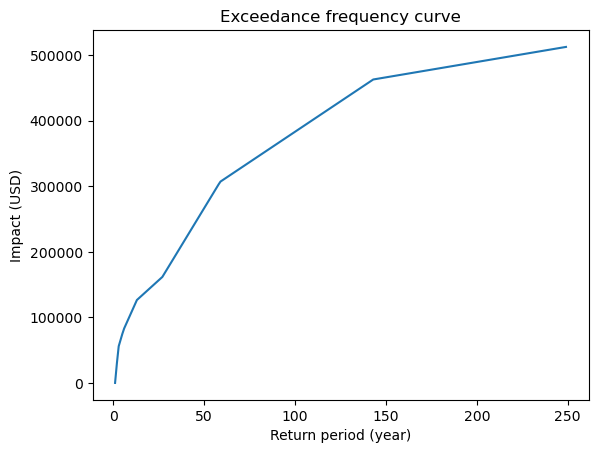

In [61]:
freqd_curve_cima.plot()

## CIMA-BEM exposure-vulnerability cross comparison

### BEM exposure - CIMA vulnerability

In [37]:
gdf_bem_subcomps = exposure.gdf_from_bem_subcomps(cntry_name, opt='full')
gdf_bem_subcomps = gdf_bem_subcomps[gdf_bem_subcomps.valhum>0.001] # filter out rows with basically no population
gdf_bem_subcomps['impf_FL'] = gdf_bem_subcomps.apply(lambda row: vulnerability.DICT_PAGER_FLIMPF_CIMA[row.se_seismo], axis=1)

In [38]:
# remove for now unnecessary cols and prepare gdf for CLIMADA Exposure
gdf_bem_subcomps.rename({'valhum' : 'value'}, axis=1)
for col in ['iso3', 'sector', 'valfis', 'se_seismo', 'bd_1_floor','bd_2_floor','bd_3_floor']:
    gdf_bem_subcomps.pop(col)

In [39]:
# Make CLIMADA Exposure with mutliply defined centroids
exp_bem_cima = Exposures(gdf_bem_subcomps)
exp_bem_cima.gdf.rename({'valhum': 'value'}, axis=1, inplace=True)
exp_bem_cima.value_unit = 'Pop. count'
exp_bem_cima.gdf['longitude'] = exp_bem_cima.gdf.geometry.x
exp_bem_cima.gdf['latitude'] = exp_bem_cima.gdf.geometry.y
exp_bem_cima.gdf = exp_bem_cima.gdf[~np.isnan(
    exp_bem_cima.gdf.latitude)]  # drop nan centroids
exp_bem_cima.gdf.head()

,id_1x,cpx,value,geometry,impf_FL,longitude,latitude
6,194457751,3,0.003283,POINT (43.40417 0.66250),15,43.404167,0.6625
7,194457751,3,0.001404,POINT (43.40417 0.66250),14,43.404167,0.6625
12,194457751,3,0.002711,POINT (43.40417 0.66250),15,43.404167,0.6625
13,194457751,3,0.001159,POINT (43.40417 0.66250),14,43.404167,0.6625
18,194457751,3,0.281569,POINT (43.40417 0.66250),15,43.404167,0.6625


In [40]:
impcalc = ImpactCalc(exp_bem_cima, impf_set_cima, haz)
impact_bem_cima = impcalc.impact()

In [41]:
impact_bem_cima.aai_agg

42430.42340001579

Turn CIMA impact functions into step functions:

In [65]:
impf_set_cima_step = ImpactFuncSet()

# The threshold of building damage after which all people are displaced. Below, no-one is displaced.
building_thes = 0.3 # 55% iDMC v1; CIMA: 30% for Somalia to 60% for other countries. 

for imp_id in impf_set_cima.get_ids(haz_type='FL'):
    impf_set_cima.get_func(fun_id=imp_id)
    y = impf_set_cima.get_func(fun_id=imp_id)[0].intensity
    x = impf_set_cima.get_func(fun_id=imp_id)[0].mdd
    flood_thres = np.interp(building_thes, x, y)
    print('ID: '+str(imp_id)+' - threshold stepfunction: '+str(flood_thres))
    impf_set_cima_step.append(
                ImpactFunc.from_step_impf(
                    intensity=(0,  flood_thres, flood_thres *10),
                    haz_type='FL',
                    impf_id=imp_id,
                    intensity_unit = 'm'
                )
    )

ID: 1 - threshold stepfunction: 1.6501727272727271
ID: 2 - threshold stepfunction: 3.0897
ID: 3 - threshold stepfunction: 5.8621
ID: 4 - threshold stepfunction: 7.25308813559322
ID: 5 - threshold stepfunction: 10.0
ID: 6 - threshold stepfunction: 1.6494416666666667
ID: 7 - threshold stepfunction: 2.8966
ID: 8 - threshold stepfunction: 4.4510233333333336
ID: 9 - threshold stepfunction: 5.833358333333334
ID: 10 - threshold stepfunction: 7.2498097560975605
ID: 11 - threshold stepfunction: 1.0249714285714286
ID: 12 - threshold stepfunction: 0.7434042553191489
ID: 13 - threshold stepfunction: 0.7436553191489361
ID: 14 - threshold stepfunction: 1.0249714285714286
ID: 15 - threshold stepfunction: 1.4075205479452055


In [66]:
impcalc = ImpactCalc(exp_bem_cima, impf_set_cima_step, haz)
impact_bem_cima = impcalc.impact()

In [67]:
impact_bem_cima.aai_agg

52485.36424177725

Print the three estimates of annual average displacement

In [69]:
impact_bem.aai_agg, impact_cima.aai_agg, impact_bem_cima.aai_agg

(107376.26532230548, 33598.28809576372, 52485.36424177725)

## A few plots

<GeoAxes: >

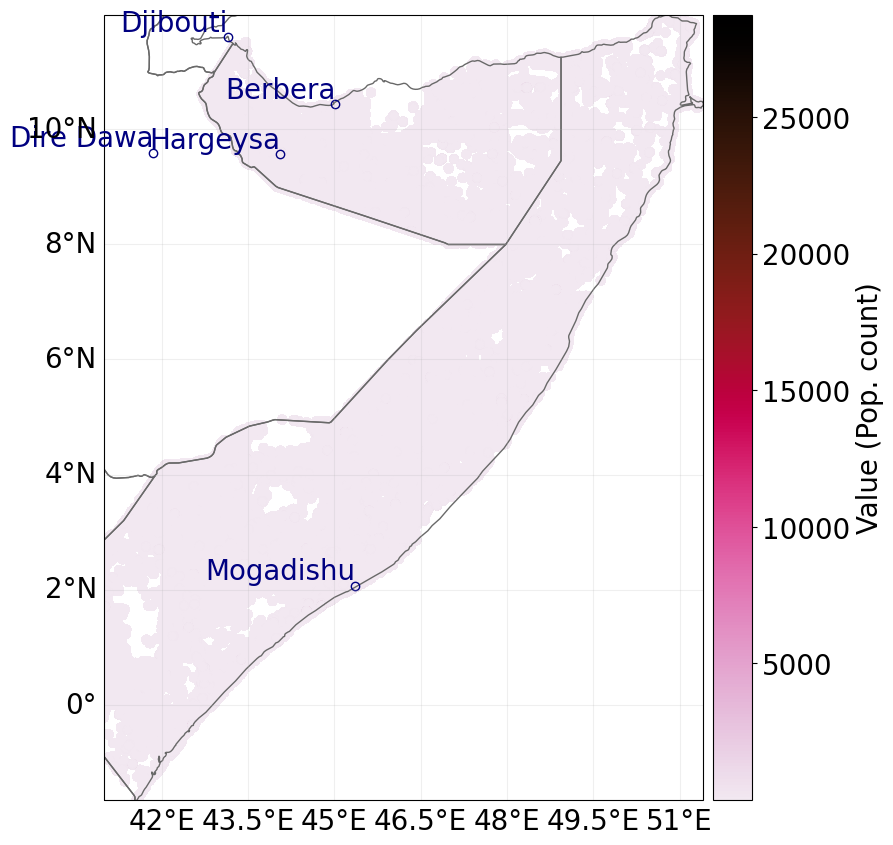

In [70]:
exp_bem_ivm.plot_scatter()

<GeoAxes: >

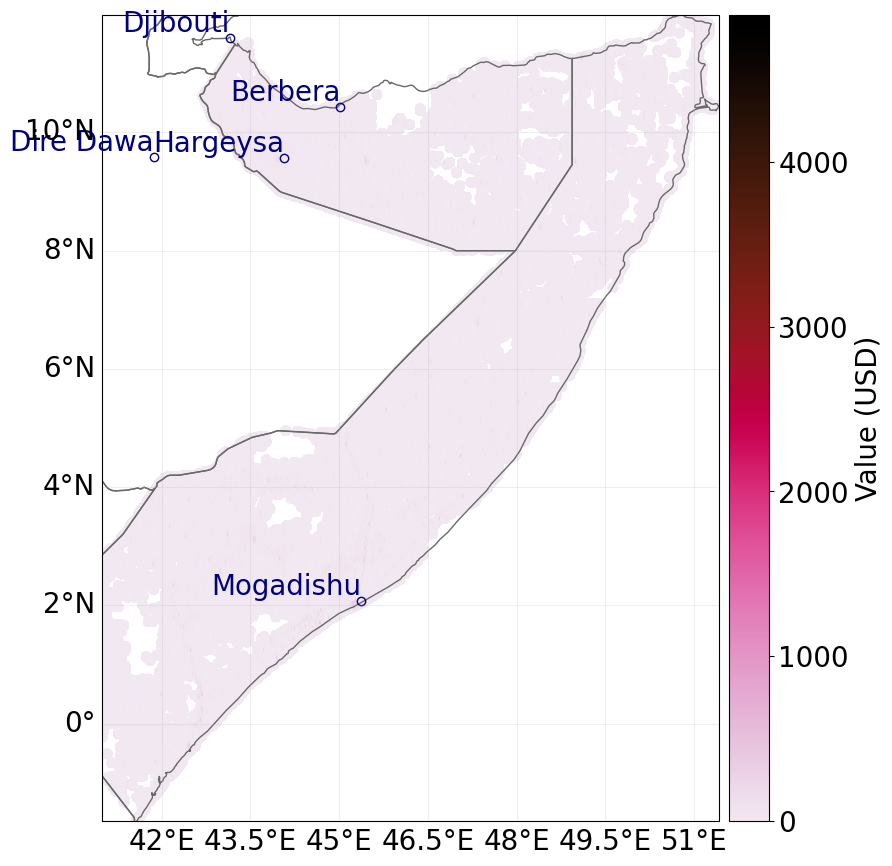

In [71]:
exp_cima.plot_scatter()